In [1]:
import numpy as np
import sys
sys.path.append("..")
import dl
import matplotlib.pyplot as plt

In [2]:
trainX_raw = np.load("../data/train_data.npy")
trainy_raw = np.load("../data/train_label.npy")
testX_raw = np.load("../data/test_data.npy")
testy_raw = np.load("../data/test_label.npy")

In [3]:
class Mlp(dl.nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = dl.Layers.DenseLayer(128, 64, initializer=dl.nn.kai_ming_normal_init)
        self.bn1 = dl.Layers.BatchNormLayer(64)
        self.dp1 = dl.Layers.DropoutLayer(0.25)
        self.fc2 = dl.Layers.DenseLayer(64, 32, initializer=dl.nn.kai_ming_normal_init)
        self.bn2 = dl.Layers.BatchNormLayer(32)
        self.dp2 = dl.Layers.DropoutLayer(0.25)
        self.fc3 = dl.Layers.DenseLayer(32, 10, initializer=dl.nn.kai_ming_normal_init)
        self.out = dl.SoftMax()

    def forward(self, X):
        out = self.fc1(X)
        out = self.bn1(out)
        out = self.dp1(out)
        out = dl.relu(out)
        out = self.fc2(out)
        out = self.bn2(out)
        out = self.dp2(out)
        out = dl.relu(out)
        out = self.fc3(out)
        return self.out(out)

In [4]:
class Mlp2HL(dl.nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = dl.Layers.DenseLayer(128, 32, initializer=dl.nn.kai_ming_normal_init)
        self.bn1 = dl.Layers.BatchNormLayer(32)
        self.dp1 = dl.Layers.DropoutLayer(0.25)
        self.fc2 = dl.Layers.DenseLayer(32, 10, initializer=dl.nn.kai_ming_normal_init)
        self.out = dl.SoftMax()

    def forward(self, X):
        out = self.fc1(X)
        out = self.bn1(out)
        out = self.dp1(out)
        out = dl.relu(out)
        out = self.fc2(out)
        return self.out(out)

In [5]:
class Mlp4HL(dl.nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = dl.Layers.DenseLayer(128, 64, initializer=dl.nn.kai_ming_normal_init)
        self.bn1 = dl.Layers.BatchNormLayer(64)
        self.dp1 = dl.Layers.DropoutLayer(0.25)
        self.fc2 = dl.Layers.DenseLayer(64, 32, initializer=dl.nn.kai_ming_normal_init)
        self.bn2 = dl.Layers.BatchNormLayer(32)
        self.dp2 = dl.Layers.DropoutLayer(0.25)
        self.fc3 = dl.Layers.DenseLayer(32, 16, initializer=dl.nn.kai_ming_normal_init)
        self.bn3 = dl.Layers.BatchNormLayer(16)
        self.dp3 = dl.Layers.DropoutLayer(0.25)
        self.fc4 = dl.Layers.DenseLayer(16, 10, initializer=dl.nn.kai_ming_normal_init)
        self.out = dl.SoftMax()

    def forward(self, X):
        out = self.fc1(X)
        out = self.bn1(out)
        out = self.dp1(out)
        out = dl.relu(out)
        out = self.fc2(out)
        out = self.bn2(out)
        out = self.dp2(out)
        out = dl.relu(out)
        out = self.fc3(out)
        out = self.bn3(out)
        out = self.dp3(out)
        out = dl.relu(out)
        out = self.fc4(out)
        return self.out(out)

In [4]:
def preprocessing(action):
    trainy = dl.utils.preprocessing.one_hot_encode(trainy_raw)
    testy = dl.utils.preprocessing.one_hot_encode(testy_raw)
    if action == "s":
        scaler = dl.utils.preprocessing.StandardScaler()
        trainx = scaler.fit(trainX_raw)
        testx = scaler.transform(testX_raw)
    elif action == "n":
        scaler = dl.utils.preprocessing.Normalizer()
        trainx = scaler.fit(trainX_raw)
        testx = scaler.transform(testX_raw)
    else:
        trainx = trainX_raw
        testx = testX_raw
    return trainx, trainy, testx, testy

In [9]:
def make_batch(bSize, *data):
    return dl.dataset.DataSet(data[0], data[1], batch_size=bSize, shuffle=True),\
            dl.dataset.DataSet(data[2], data[3], batch_size=bSize, shuffle=True)

In [8]:
def train(model, loss_func, scheduler, optimizer):
    model.train()
    train_loss_epoch = 0
    train_accuracy_epoch = 0
    for x, y in trainset:
        optimizer.zero_grad()
        yhat = model(x)
        loss = loss_func(y, yhat)
        loss.backward()
        optimizer.step()
        train_loss_epoch += loss.item
        train_accuracy_epoch += dl.metrics.accuracy(y, yhat)
    train_loss_epoch /= len(trainset)
    train_accuracy_epoch /= len(trainset)
    scheduler.step(train_loss_epoch)
    model.eval()
    test_loss_epoch = 0
    test_accuracy_epoch = 0
    for x, y in testset:
        yhat = model(x)
        loss = loss_func(y, yhat)
        test_loss_epoch += np.mean(loss.item)
        test_accuracy_epoch += dl.metrics.accuracy(y, yhat)
    test_loss_epoch /= len(testset)
    test_accuracy_epoch /= len(testset)
    print(f"Train loss {train_loss_epoch}, Train acc: {train_accuracy_epoch}, "
          f"Test loss: {test_loss_epoch}, Test acc: {test_accuracy_epoch}")
    return train_loss_epoch, train_accuracy_epoch,\
            test_loss_epoch, test_accuracy_epoch

trainx, trainy, testx, testy = preprocessing(None)
trainset, testset = make_batch(128)


model3HL = Mlp3HL()
model4HL = Mlp4HL()
model2HL = Mlp2HL()

models = [model2HL, model3HL, model4HL]
res = []

for i in range(len(models)):
    loss_func = dl.metrics.CrossEntropyLoss()
    optimizer = dl.optimizer.SGDOptimizer(models[i].get_parameters(), lr=1e-3, momentum=0.9, weight_decay=0.02)
    scheduler = dl.optimizer.LRDecayScheduler(optimizer)
    param = [models[i], loss_func, scheduler, optimizer]
    session = dl.utils.EarlyStoppingPipe(models[i], 
                                         train, 
                                         1000, 
                                         params=param, 
                                         value_on_watch=3)
    session.run()
    res.append(session.get_evaluation_data())

Epoch 1: Train loss 0.189398137864149, Train acc: 0.32325721153846154, Test loss: 0.17075665763002879, Test acc: 0.40614983974358976
Epoch 2: Train loss 0.17425333888530675, Train acc: 0.38131009615384615, Test loss: 0.16486105737703138, Test acc: 0.42197516025641024
Epoch 3: Train loss 0.17056121444295055, Train acc: 0.3948517628205128, Test loss: 0.1604091625454383, Test acc: 0.4328926282051282
Epoch 4: Train loss 0.1676766000067704, Train acc: 0.4035857371794872, Test loss: 0.15846462671436545, Test acc: 0.43960336538461536
Epoch 5: Train loss 0.16586159375844406, Train acc: 0.4085536858974359, Test loss: 0.15637764909799304, Test acc: 0.44931891025641024
Epoch 6: Train loss 0.16412585812588357, Train acc: 0.4139222756410256, Test loss: 0.15496463264579965, Test acc: 0.4512219551282051
Epoch 7: Train loss 0.1629874580875358, Train acc: 0.41716746794871795, Test loss: 0.1539660044008627, Test acc: 0.45703125
Epoch 8: Train loss 0.1625810294734836, Train acc: 0.41969150641025643, Test

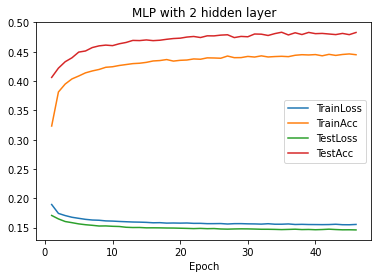

<Figure size 432x288 with 0 Axes>

In [16]:
# HL2
x = [i+1 for i in range(len(res[0]))]
train_loss = [i[0] for i in res[0]]
train_acc = [i[1] for i in res[0]]
test_loss = [i[2] for i in res[0]]
test_acc = [i[3] for i in res[0]]

plt.plot(x, train_loss, label="TrainLoss")
plt.plot(x, train_acc, label="TrainAcc")
plt.plot(x, test_loss, label="TestLoss")
plt.plot(x, test_acc, label="TestAcc")
plt.title("MLP with 2 hidden layer")
plt.xlabel("Epoch")
plt.legend()
plt.show()
plt.savefig("MLP2HL.png")

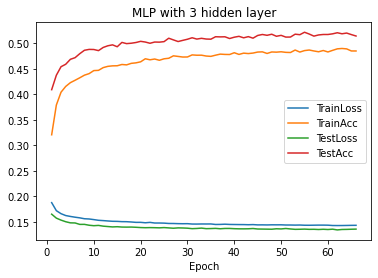

<Figure size 432x288 with 0 Axes>

In [17]:
# HL3
data = res[1]
x = [i+1 for i in range(len(data))]
train_loss = [i[0] for i in data]
train_acc = [i[1] for i in data]
test_loss = [i[2] for i in data]
test_acc = [i[3] for i in data]

plt.plot(x, train_loss, label="TrainLoss")
plt.plot(x, train_acc, label="TrainAcc")
plt.plot(x, test_loss, label="TestLoss")
plt.plot(x, test_acc, label="TestAcc")
plt.title("MLP with 3 hidden layer")
plt.xlabel("Epoch")
plt.legend()
plt.show()
plt.savefig("MLP3HL.png")

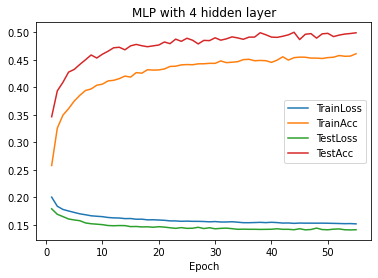

<Figure size 432x288 with 0 Axes>

In [18]:
# HL3
data = res[2]
x = [i+1 for i in range(len(data))]
train_loss = [i[0] for i in data]
train_acc = [i[1] for i in data]
test_loss = [i[2] for i in data]
test_acc = [i[3] for i in data]

plt.plot(x, train_loss, label="TrainLoss")
plt.plot(x, train_acc, label="TrainAcc")
plt.plot(x, test_loss, label="TestLoss")
plt.plot(x, test_acc, label="TestAcc")
plt.title("MLP with 4 hidden layer")
plt.xlabel("Epoch")
plt.legend()
plt.show()
plt.savefig("MLP4HL.png")

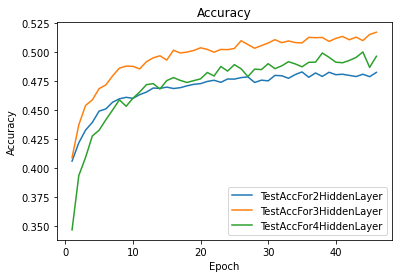

<Figure size 432x288 with 0 Axes>

In [21]:
x = [i+1 for i in range(46)]
test_acc2 = [i[3] for i in res[0]]
test_acc3 = [i[3] for i in res[1]][:len(test_acc2)]
test_acc4 = [i[3] for i in res[2]][:len(test_acc2)]

plt.plot(x, test_acc2, label="TestAccFor2HiddenLayer")
plt.plot(x, test_acc3, label="TestAccFor3HiddenLayer")
plt.plot(x, test_acc4, label="TestAccFor4HiddenLayer")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
plt.savefig("MLPALL.png")

In [22]:
def train(model, loss_func, scheduler, optimizer, trainset, testset):
    model.train()
    train_loss_epoch = 0
    train_accuracy_epoch = 0
    for x, y in trainset:
        optimizer.zero_grad()
        yhat = model(x)
        loss = loss_func(y, yhat)
        loss.backward()
        optimizer.step()
        train_loss_epoch += loss.item
        train_accuracy_epoch += dl.metrics.accuracy(y, yhat)
    train_loss_epoch /= len(trainset)
    train_accuracy_epoch /= len(trainset)
    scheduler.step(train_loss_epoch)
    model.eval()
    test_loss_epoch = 0
    test_accuracy_epoch = 0
    for x, y in testset:
        yhat = model(x)
        loss = loss_func(y, yhat)
        test_loss_epoch += np.mean(loss.item)
        test_accuracy_epoch += dl.metrics.accuracy(y, yhat)
    test_loss_epoch /= len(testset)
    test_accuracy_epoch /= len(testset)
    print(f"Train loss {train_loss_epoch}, Train acc: {train_accuracy_epoch}, "
          f"Test loss: {test_loss_epoch}, Test acc: {test_accuracy_epoch}")
    return train_loss_epoch, train_accuracy_epoch,\
            test_loss_epoch, test_accuracy_epoch

trainx, trainy, testx, testy = preprocessing(None)


model64b = Mlp3HL()
model128b = Mlp3HL()
model256b = Mlp3HL()

models = [model64b, model128b, model256b]
bsize = [64, 128, 256]
res = []

for i in range(len(models)):
    loss_func = dl.metrics.CrossEntropyLoss()
    optimizer = dl.optimizer.SGDOptimizer(models[i].get_parameters(), lr=1e-3, momentum=0.9, weight_decay=0.02)
    scheduler = dl.optimizer.LRDecayScheduler(optimizer)
    trainset, testset = make_batch(bsize[i])
    param = [models[i], loss_func, scheduler, optimizer, trainset, testset]
    
    session = dl.utils.EarlyStoppingPipe(models[i], 
                                         train, 
                                         1000, 
                                         params=param, 
                                         value_on_watch=3)
    session.run()
    res.append(session.get_evaluation_data())

Epoch 1: Train loss 0.18568230641050168, Train acc: 0.3273647567221511, Test loss: 0.1641732009196133, Test acc: 0.42037259615384615
Epoch 2: Train loss 0.17032973100292728, Train acc: 0.38422295134443024, Test loss: 0.15689070623283352, Test acc: 0.441005608974359
Epoch 3: Train loss 0.16557141399191327, Train acc: 0.40328905249679897, Test loss: 0.15238398722702434, Test acc: 0.4602363782051282
Epoch 4: Train loss 0.16277670747659576, Train acc: 0.41545294494238155, Test loss: 0.15099985238038988, Test acc: 0.4664463141025641
Epoch 5: Train loss 0.16063685449881746, Train acc: 0.42091469270166454, Test loss: 0.14845409171609417, Test acc: 0.4680488782051282
Epoch 6: Train loss 0.15867523646760465, Train acc: 0.42995758642765686, Test loss: 0.14686712447759534, Test acc: 0.4781650641025641
Epoch 7: Train loss 0.15722165405500682, Train acc: 0.435059218950064, Test loss: 0.14554111353715282, Test acc: 0.48227163461538464
Epoch 8: Train loss 0.15628477080270026, Train acc: 0.43743998079

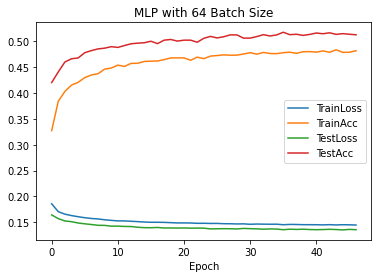

<Figure size 432x288 with 0 Axes>

In [24]:
# b64
x = [i for i in range(len(res[0]))]
train_loss = [i[0] for i in res[0]]
train_acc = [i[1] for i in res[0]]
test_loss = [i[2] for i in res[0]]
test_acc = [i[3] for i in res[0]]

plt.plot(x, train_loss, label="TrainLoss")
plt.plot(x, train_acc, label="TrainAcc")
plt.plot(x, test_loss, label="TestLoss")
plt.plot(x, test_acc, label="TestAcc")
plt.title("MLP with 64 Batch Size")
plt.xlabel("Epoch")
plt.legend()
plt.show()
plt.savefig("Figures/BatchSize/64.png")

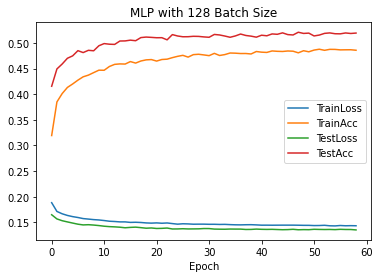

<Figure size 432x288 with 0 Axes>

In [25]:
# b128
data = res[1]
x = [i for i in range(len(data))]
train_loss = [i[0] for i in data]
train_acc = [i[1] for i in data]
test_loss = [i[2] for i in data]
test_acc = [i[3] for i in data]

plt.plot(x, train_loss, label="TrainLoss")
plt.plot(x, train_acc, label="TrainAcc")
plt.plot(x, test_loss, label="TestLoss")
plt.plot(x, test_acc, label="TestAcc")
plt.title("MLP with 128 Batch Size")
plt.xlabel("Epoch")
plt.legend()
plt.show()
plt.savefig("Figures/BatchSize/128.png")

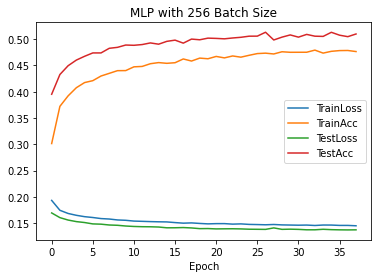

<Figure size 432x288 with 0 Axes>

In [26]:
# b256
data = res[2]
x = [i for i in range(len(data))]
train_loss = [i[0] for i in data]
train_acc = [i[1] for i in data]
test_loss = [i[2] for i in data]
test_acc = [i[3] for i in data]

plt.plot(x, train_loss, label="TrainLoss")
plt.plot(x, train_acc, label="TrainAcc")
plt.plot(x, test_loss, label="TestLoss")
plt.plot(x, test_acc, label="TestAcc")
plt.title("MLP with 256 Batch Size")
plt.xlabel("Epoch")
plt.legend()
plt.show()
plt.savefig("Figures/BatchSize/256.png")

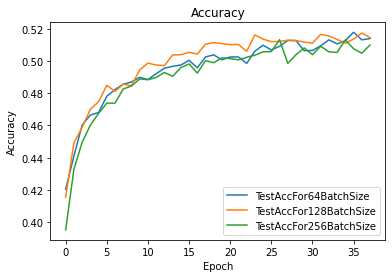

<Figure size 432x288 with 0 Axes>

In [32]:
sz = min([len(res[0]), len(res[1]), len(res[2])])

test_acc64 = [i[3] for i in res[0]][:sz]
test_acc128 = [i[3] for i in res[1]][:sz]
test_acc256 = [i[3] for i in res[2]][:sz]

x = [i for i in range(sz)]
plt.plot(x, test_acc64, label="TestAccFor64BatchSize")
plt.plot(x, test_acc128, label="TestAccFor128BatchSize")
plt.plot(x, test_acc256, label="TestAccFor256BatchSize")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
plt.savefig("Figures/BatchSize/ALL.png")

In [10]:
def train(model, loss_func, scheduler, optimizer, trainset, testset):
    model.train()
    train_loss_epoch = 0
    train_accuracy_epoch = 0
    for x, y in trainset:
        optimizer.zero_grad()
        yhat = model(x)
        loss = loss_func(y, yhat)
        loss.backward()
        optimizer.step()
        train_loss_epoch += loss.item
        train_accuracy_epoch += dl.metrics.accuracy(y, yhat)
    train_loss_epoch /= len(trainset)
    train_accuracy_epoch /= len(trainset)
    scheduler.step(train_loss_epoch)
    model.eval()
    test_loss_epoch = 0
    test_accuracy_epoch = 0
    for x, y in testset:
        yhat = model(x)
        loss = loss_func(y, yhat)
        test_loss_epoch += loss.item
        test_accuracy_epoch += dl.metrics.accuracy(y, yhat)
    test_loss_epoch /= len(testset)
    test_accuracy_epoch /= len(testset)
    print(f"Train loss {train_loss_epoch}, Train acc: {train_accuracy_epoch}, "
          f"Test loss: {test_loss_epoch}, Test acc: {test_accuracy_epoch}")
    return train_loss_epoch, train_accuracy_epoch,\
            test_loss_epoch, test_accuracy_epoch


modelstd = Mlp()
modelnp = Mlp()

models = [modelstd, modelnp]
norm = ["s", None]
res = []

for i in range(len(models)):
    loss_func = dl.metrics.CrossEntropyLoss()
    optimizer = dl.optimizer.SGDOptimizer(models[i].get_parameters(), lr=1e-3, momentum=0.9, weight_decay=0.02)
    scheduler = dl.optimizer.LRDecayScheduler(optimizer)
    data = preprocessing(norm[i])
    trainset, testset = make_batch(128, *data)
    param = [models[i], loss_func, scheduler, optimizer, trainset, testset]
    
    session = dl.utils.EarlyStoppingPipe(models[i], 
                                         train, 
                                         1000, 
                                         params=param, 
                                         value_on_watch=3)
    session.run()
    res.append(session.get_evaluation_data())

Epoch 1: Train loss 0.18908012249984527, Train acc: 0.31582532051282053, Test loss: 0.1627187240040733, Test acc: 0.4192708333333333
Epoch 2: Train loss 0.1676691721005749, Train acc: 0.39571314102564104, Test loss: 0.15398631077732278, Test acc: 0.44130608974358976
Epoch 3: Train loss 0.16295995304274194, Train acc: 0.4130008012820513, Test loss: 0.1516609513171117, Test acc: 0.4528245192307692
Epoch 4: Train loss 0.1589752796063205, Train acc: 0.4259415064102564, Test loss: 0.14782848167105517, Test acc: 0.46664663461538464
Epoch 5: Train loss 0.15633852028467612, Train acc: 0.43525641025641026, Test loss: 0.1457115878080919, Test acc: 0.47375801282051283
Epoch 6: Train loss 0.15474419247864735, Train acc: 0.4405649038461538, Test loss: 0.14423600267879613, Test acc: 0.47936698717948717
Epoch 7: Train loss 0.15316121779018882, Train acc: 0.44587339743589743, Test loss: 0.14333643381622968, Test acc: 0.47966746794871795
Epoch 8: Train loss 0.1513442188643016, Train acc: 0.454266826923

KeyboardInterrupt: 